# Resistance plant gene prediction - Modeling
---

## Libraries

In [2]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Data preparation and scaling
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler

# Tokenization
from tensorflow.keras.preprocessing.text import Tokenizer

# Modeling library
import tensorflow as tf
from tensorflow.keras.models import Model

# Modeling Layers
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.layers import MultiHeadAttention, Embedding, GlobalAveragePooling1D, Dropout, LayerNormalization

# Speed up the model's training
from tensorflow.keras import mixed_precision


# Helper functions and Layers
import helper_functions as hf
from Positional_encoding import PositionalEncoding

2024-05-16 01:29:20.803110: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-16 01:29:20.823718: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 01:29:20.823729: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 01:29:20.824327: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-16 01:29:20.828398: I tensorflow/core/platform/cpu_feature_guar

## Data loading

In [3]:
proteins = pd.read_csv('Data/train.csv')

In [4]:
proteins.head()

,ID,Sequence,Label
0,0,MDSRMDQYEVMEQIGRGAFGAAILVNHKTEKKKYVLKKIRLARQTE...,0
1,4,MAPKAEKKPAEKKPAEEKAGEKAPAAGKKPKAEKRLPASKGEKGGE...,0
2,5,MLELHFEFIDLNQPKMYKFVVCLLTLSFLLLSGLSNTALARVHHES...,0
3,6,MAEPELVNGGVKENKLWKGVFAVSGIMSTLVIYGVLQEKIMRVPYG...,0
4,7,MTSCGCLVLEKVEDHGGEAAGRGRGRLAQGGGGGGGGCGSCAGEWR...,0


In [5]:
proteins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14161 entries, 0 to 14160
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        14161 non-null  int64 
 1   Sequence  14161 non-null  object
 2   Label     14161 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 332.0+ KB


In [6]:
proteins[proteins.duplicated()].shape

(0, 3)

In [7]:
labels = pd.DataFrame(proteins['Label'])
labels.head()

,Label
0,0
1,0
2,0
3,0
4,0


In [8]:
sequences = proteins['Sequence']
sequences.head()

0    MDSRMDQYEVMEQIGRGAFGAAILVNHKTEKKKYVLKKIRLARQTE...
1    MAPKAEKKPAEKKPAEEKAGEKAPAAGKKPKAEKRLPASKGEKGGE...
2    MLELHFEFIDLNQPKMYKFVVCLLTLSFLLLSGLSNTALARVHHES...
3    MAEPELVNGGVKENKLWKGVFAVSGIMSTLVIYGVLQEKIMRVPYG...
4    MTSCGCLVLEKVEDHGGEAAGRGRGRLAQGGGGGGGGCGSCAGEWR...
Name: Sequence, dtype: object

## Data Preparation

### Tokenization

#### Char level

* Tokenize the sequences on char level

In [9]:
# Tokenize on char level
tokenizer1 = Tokenizer(char_level=True)
tokenizer1.fit_on_texts(sequences)
sequences_1p = tokenizer1.texts_to_sequences(sequences)

# Padd the sequences to match all the length of the biggest
sequences_1p = pad_sequences(sequences_1p, padding='post')

In [10]:
sequences_1p

array([[17,  9,  2, ...,  0,  0,  0],
       [17,  3, 12, ...,  0,  0,  0],
       [17,  1,  6, ...,  0,  0,  0],
       ...,
       [17, 16, 13, ...,  0,  0,  0],
       [17,  3,  3, ...,  0,  0,  0],
       [17,  4, 10, ...,  0,  0,  0]], dtype=int32)

* Max sequence length

In [11]:
len(sequences_1p[0])

2028

#### 2 Amino Pairs

* Split the sequences per 2 aminos

In [12]:
dipeptide_sequences = hf.split_sequences(sequences, step=2)
pd.DataFrame(dipeptide_sequences[500])

,0
0,MA
1,SA
2,EG
3,GG
4,DK
...,...
113,GC
114,PV
115,MR
116,GA


In [13]:
sequences[500]

'MASAEGGGDKYRSFLHGDGEKKTVWRHGAPPNYDLVNKLFEEERTKEWAEGSVEEKVQRLLKTWEMEMVHKVRPEDQKSVNLKNYSASTNGLKPLTREEVMAMGGYNAFLATTLPPEHRIYDPEAESVESATSTFLTAFPRGFAIEVLDVYSSPSAPRIAFKFRHWGYMEGPFKGHPPHGGRVEFFGVCVFHVDEDTKVEKAEFFYERGNFLASFLTAPAASASASGCPVMRGAD'

In [14]:
tokenizer2 = Tokenizer(char_level=False)
tokenizer2.fit_on_texts(dipeptide_sequences)
sequences_2p = tokenizer2.texts_to_sequences(dipeptide_sequences)
sequences_2p = pad_sequences(sequences_2p, padding='post')

In [15]:
sequences_2p

array([[257,  54, 257, ...,   0,   0,   0],
       [132, 151,  55, ...,   0,   0,   0],
       [196,  19, 323, ...,   0,   0,   0],
       ...,
       [370, 182, 250, ...,   0,   0,   0],
       [132,  94, 252, ...,   0,   0,   0],
       [231, 318,  75, ...,   0,   0,   0]], dtype=int32)

* Max length

In [16]:
len(sequences_2p[0])

1014

#### 3 Amino Pairs

* Split the sequences per 3 aminos

In [17]:
tripeptide_sequences = hf.split_sequences(sequences, step=3)
pd.DataFrame(tripeptide_sequences[500])

,0
0,MAS
1,AEG
2,GGD
3,KYR
4,SFL
...,...
74,ASA
75,SGC
76,PVM
77,RGA


In [18]:
sequences[500]

'MASAEGGGDKYRSFLHGDGEKKTVWRHGAPPNYDLVNKLFEEERTKEWAEGSVEEKVQRLLKTWEMEMVHKVRPEDQKSVNLKNYSASTNGLKPLTREEVMAMGGYNAFLATTLPPEHRIYDPEAESVESATSTFLTAFPRGFAIEVLDVYSSPSAPRIAFKFRHWGYMEGPFKGHPPHGGRVEFFGVCVFHVDEDTKVEKAEFFYERGNFLASFLTAPAASASASGCPVMRGAD'

In [19]:
tokenizer3 = Tokenizer(char_level=False)
tokenizer3.fit_on_texts(tripeptide_sequences)
sequences_3p = tokenizer3.texts_to_sequences(tripeptide_sequences)
sequences_3p = pad_sequences(sequences_3p, padding='post')

In [20]:
sequences_3p

array([[2182, 5456, 5868, ...,    0,    0,    0],
       [1956,  766, 1178, ...,    0,    0,    0],
       [1946, 3717, 2905, ...,    0,    0,    0],
       ...,
       [6744, 5076, 3048, ...,    0,    0,    0],
       [ 233, 4150, 2315, ...,    0,    0,    0],
       [3401, 4360, 1172, ...,    0,    0,    0]], dtype=int32)

* Max length

In [21]:
len(sequences_3p[0])

676

### Train Test Split

#### Char level split

In [22]:
sequences_1p_train, sequences_1p_test, labels_1p_train, labels_1p_test = train_test_split(sequences_1p, labels, test_size=0.2, random_state=33)

In [23]:
print('Training shapes: ', sequences_1p_train.shape, labels_1p_train.shape)
print('Test shapes: ', sequences_1p_test.shape, labels_1p_test.shape)

Training shapes:  (11328, 2028) (11328, 1)
Test shapes:  (2833, 2028) (2833, 1)


In [24]:
scaler = StandardScaler()
sequences_1p_train_scaled = scaler.fit_transform(sequences_1p_train)
sequences_1p_test_scaled = scaler.fit_transform(sequences_1p_test)

In [25]:
# pd.DataFrame(sequences_1p_train).to_csv('Data/Prepared_Data/1_Amino_Pair/train.csv')
# pd.DataFrame(sequences_1p_test).to_csv('Data/Prepared_Data/1_Amino_Pair/test.csv')

# pd.DataFrame(labels_1p_train).to_csv('Data/Prepared_Data/1_Amino_Pair/labels_train.csv')
# pd.DataFrame(labels_1p_test).to_csv('Data/Prepared_Data/1_Amino_Pair/labels_test.csv')

In [26]:
# pd.DataFrame(sequences_1p_train_scaled).to_csv('Data/Prepared_Data/1_Amino_Pair/train_scaled.csv')
# pd.DataFrame(sequences_1p_test_scaled).to_csv('Data/Prepared_Data/1_Amino_Pair/test_scaled.csv')

#### 2 Aminos split

In [27]:
sequences_2p_train, sequences_2p_test, labels_2p_train, labels_2p_test = train_test_split(sequences_2p, labels, test_size=0.2, random_state=33)

In [28]:
print('Training shapes: ', sequences_2p_train.shape, labels_2p_train.shape)
print('Test shapes: ', sequences_2p_test.shape, labels_2p_test.shape)

Training shapes:  (11328, 1014) (11328, 1)
Test shapes:  (2833, 1014) (2833, 1)


In [29]:
sequences_2p_train_scaled = scaler.fit_transform(sequences_2p_train)
sequences_2p_test_scaled = scaler.fit_transform(sequences_2p_test)

In [30]:
# pd.DataFrame(sequences_2p_train).to_csv('Data/Prepared_Data/2_Amino_Pair/train.csv')
# pd.DataFrame(sequences_2p_test).to_csv('Data/Prepared_Data/2_Amino_Pair/test.csv')

# pd.DataFrame(labels_2p_train).to_csv('Data/Prepared_Data/2_Amino_Pair/labels_train.csv')
# pd.DataFrame(labels_2p_test).to_csv('Data/Prepared_Data/2_Amino_Pair/labels_test.csv')

In [31]:
# pd.DataFrame(sequences_2p_train_scaled).to_csv('Data/Prepared_Data/2_Amino_Pair/train_scaled.csv')
# pd.DataFrame(sequences_2p_test_scaled).to_csv('Data/Prepared_Data/2_Amino_Pair/test_scaled.csv')

#### 3 Aminos split

In [32]:
sequences_3p_train, sequences_3p_test, labels_3p_train, labels_3p_test = train_test_split(sequences_3p, labels, test_size=0.2, random_state=33)

In [33]:
print('Training shapes: ', sequences_3p_train.shape, labels_3p_train.shape)
print('Test shapes: ', sequences_3p_test.shape, labels_3p_test.shape)

Training shapes:  (11328, 676) (11328, 1)
Test shapes:  (2833, 676) (2833, 1)


In [34]:
sequences_3p_train_scaled = scaler.fit_transform(sequences_3p_train)
sequences_3p_test_scaled = scaler.fit_transform(sequences_3p_test)

In [35]:
# pd.DataFrame(sequences_3p_train).to_csv('Data/Prepared_Data/3_Amino_Pair/train.csv')
# pd.DataFrame(sequences_3p_test).to_csv('Data/Prepared_Data/3_Amino_Pair/test.csv')

# pd.DataFrame(labels_3p_train).to_csv('Data/Prepared_Data/3_Amino_Pair/labels_train.csv')
# pd.DataFrame(labels_3p_test).to_csv('Data/Prepared_Data/3_Amino_Pair/labels_test.csv')

In [36]:
# pd.DataFrame(sequences_3p_train_scaled).to_csv('Data/Prepared_Data/3_Amino_Pair/train_scaled.csv')
# pd.DataFrame(sequences_3p_test_scaled).to_csv('Data/Prepared_Data/3_Amino_Pair/test_scaled.csv')

## Mixed precision

* Set up mix precision before modeling to speed up the training

In [37]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3060 (UUID: GPU-ab9b9fbd-4e42-e44a-c243-d1a9ea6686fe)


In [38]:
tf.config.list_physical_devices()

2024-05-16 01:29:25.845301: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-16 01:29:25.861399: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-16 01:29:25.861442: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [39]:
mixed_precision.set_global_policy(policy='mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


2024-05-16 01:29:25.874896: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [40]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Modeling (Char level)

In [40]:
sequence_len = sequences_1p_train.shape[1]
voc_size = len(tokenizer1.word_index)
embedding_dim = 400

### LSTM

In [41]:
inputs = Input(shape=(sequence_len), name='Input')
embeddings = Embedding(input_dim=voc_size, output_dim=embedding_dim, input_length=sequence_len, name='Embeddings')(inputs)

lstms1 = LSTM(20, name='LSTM_layer_1', return_sequences=True)(embeddings)
x = Dropout(0.1)(lstms1)
lstms2 = LSTM(20, name='LSTM_layer_2', return_sequences=True)(x)
x = Dropout(0.1)(lstms1)
lstms3 = LSTM(20, name='LSTM_layer_3')(x)

dense1 = Dense(10, activation='relu', name='Dense_1')(lstms3)
dense2 = Dense(5, activation='relu', name='Dense_2')(dense1)

outputs = Dense(1, activation=tf.keras.activations.hard_sigmoid, name='Output')(dense2)

2024-05-15 23:48:30.647222: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-15 23:48:30.647283: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-15 23:48:30.647310: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-15 23:48:30.777882: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-15 23:48:30.777932: I external/local_xla/xla/stream_executor

In [42]:
model_1 = Model(inputs=inputs, outputs=outputs)
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2028)]            0         
                                                                 
 Embeddings (Embedding)      (None, 2028, 400)         9200      
                                                                 
 LSTM_layer_1 (LSTM)         (None, 2028, 20)          33680     
                                                                 
 dropout_1 (Dropout)         (None, 2028, 20)          0         
                                                                 
 LSTM_layer_3 (LSTM)         (None, 20)                3280      
                                                                 
 Dense_1 (Dense)             (None, 10)                210       
                                                                 
 Dense_2 (Dense)             (None, 5)                 55    

In [43]:
model_1.compile(optimizer=tf.keras.optimizers.Adamax(), loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])

In [44]:
history = model_1.fit(sequences_1p_train, labels_1p_train, epochs=10, batch_size=25)

Epoch 1/2


2024-05-15 23:48:33.213001: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-15 23:48:34.386720: I external/local_xla/xla/service/service.cc:168] XLA service 0x7eff53281940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-15 23:48:34.386761: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-05-15 23:48:34.397445: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1715806114.476321     910 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


454/454 [==============================] - 91s 195ms/step - loss: 0.3207 - accuracy: 0.9079
Epoch 2/2
454/454 [==============================] - 87s 192ms/step - loss: 0.3038 - accuracy: 0.9098


In [45]:
predictions = model_1.predict(sequences_1p_test)

89/89 [==============================] - 7s 77ms/step


In [46]:
predictions = hf.model_accuracy(labels_1p_test, predictions)

Accuracy:  0.9110483586304271
Loss:  0.3018


In [47]:
hf.class_report(labels_1p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.91      1.00      0.95      2581
    Positive       0.00      0.00      0.00       252

    accuracy                           0.91      2833
   macro avg       0.46      0.50      0.48      2833
weighted avg       0.83      0.91      0.87      2833



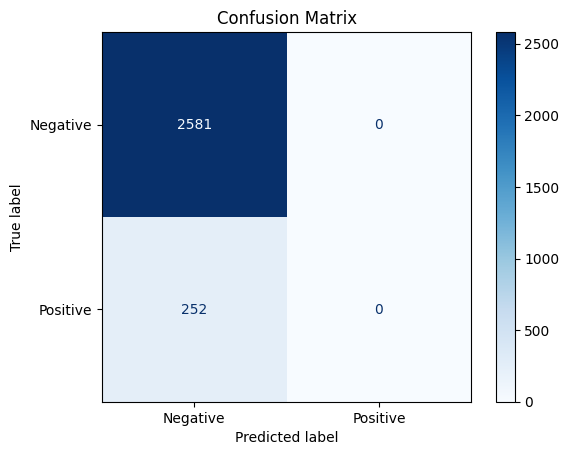

In [48]:
hf.conf_matrix(labels_1p_test, predictions, '1_pair/1p_lstm_baseline_cm')

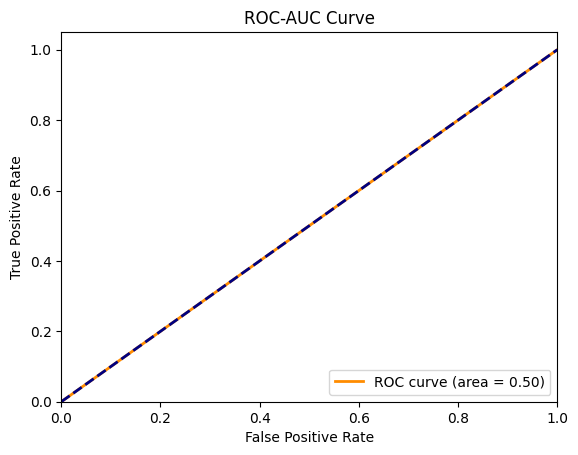

In [49]:
hf.roc_auc_curve(labels_1p_test, predictions, '1_pair/1p_lstm_baseline_roc_auc')

In [ ]:
hf.plot_history(history)

### Transformers

In [50]:
input_layer = Input(shape=(sequence_len), dtype=tf.float32, name='Input')

x = Embedding(input_dim=voc_size, output_dim=embedding_dim, name='Embeddings')(input_layer)

x = PositionalEncoding(position=sequence_len, d_model=embedding_dim)(x)

attention = MultiHeadAttention(num_heads=6, key_dim=embedding_dim, name='Attention1')(x, x)
attention = tf.cast(attention, dtype=tf.float32)  

x = LayerNormalization(epsilon=1e-6, name='LayerNorm1')(x + attention)

dense = Dense(embedding_dim, activation='relu', name='Dense1')(x)
dense = Dense(embedding_dim, activation='relu', name='Dense2')(dense)

x = LayerNormalization(epsilon=1e-6, name='LayerNorm2')(x + dense)
x = GlobalAveragePooling1D(name='GAPooling1D')(x)
x = Dropout(0.1, name='Dropout')(x)

outputs_layer = Dense(1, activation="sigmoid", name='Output')(x)

In [51]:
transformer_1 = Model(inputs=input_layer, outputs=outputs_layer)
transformer_1.compile(optimizer=tf.keras.optimizers.Adamax(), loss=tf.keras.losses.binary_crossentropy, metrics=["accuracy"])

In [52]:
transformer_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 2028)]               0         []                            
                                                                                                  
 Embeddings (Embedding)      (None, 2028, 400)            9200      ['Input[0][0]']               
                                                                                                  
 positional_encoding (Posit  (None, 2028, 400)            0         ['Embeddings[0][0]']          
 ionalEncoding)                                                                                   
                                                                                                  
 Attention1 (MultiHeadAtten  (None, 2028, 400)            3847600   ['positional_encoding[0]

In [53]:
history = transformer_1.fit(sequences_1p_train, labels_1p_train, epochs=10, batch_size=32)

Epoch 1/10
354/354 [==============================] - 173s 484ms/step - loss: 0.3331 - accuracy: 0.9075
Epoch 2/10
354/354 [==============================] - 171s 484ms/step - loss: 0.3087 - accuracy: 0.9098
Epoch 3/10
354/354 [==============================] - 171s 484ms/step - loss: 0.3071 - accuracy: 0.9098
Epoch 4/10
354/354 [==============================] - 172s 486ms/step - loss: 0.3103 - accuracy: 0.9098
Epoch 5/10
354/354 [==============================] - 172s 486ms/step - loss: 0.3063 - accuracy: 0.9098
Epoch 6/10
354/354 [==============================] - 171s 484ms/step - loss: 0.3058 - accuracy: 0.9098
Epoch 7/10
354/354 [==============================] - 173s 487ms/step - loss: 0.2997 - accuracy: 0.9096
Epoch 8/10
354/354 [==============================] - 174s 491ms/step - loss: 0.2919 - accuracy: 0.9115
Epoch 9/10
354/354 [==============================] - 172s 486ms/step - loss: 0.2892 - accuracy: 0.9135
Epoch 10/10
354/354 [==============================] - 172s 485m

In [54]:
predictions = transformer_1.predict(sequences_1p_test)

89/89 [==============================] - 16s 180ms/step


In [55]:
predictions = hf.model_accuracy(labels_1p_test, predictions)

Accuracy:  0.9114013413342746
Loss:  0.2927


In [56]:
hf.class_report(labels_1p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.92      0.99      0.95      2581
    Positive       0.51      0.12      0.19       252

    accuracy                           0.91      2833
   macro avg       0.71      0.55      0.57      2833
weighted avg       0.88      0.91      0.89      2833



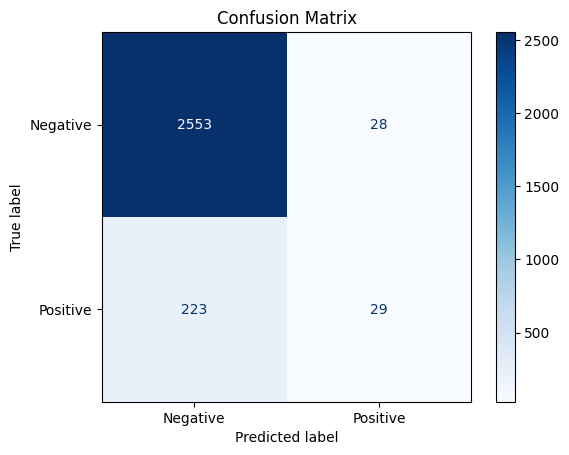

In [57]:
hf.conf_matrix(labels_1p_test, predictions, '1_pair/1p_transformer_1_cm')

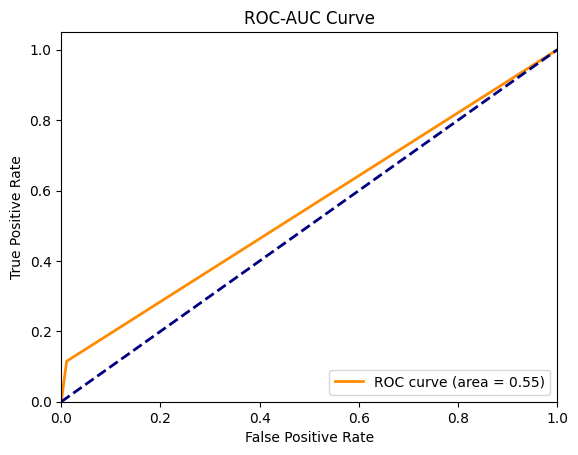

In [58]:
hf.roc_auc_curve(labels_1p_test, predictions, '1_pair/1p_transformer_1_roc_auc')

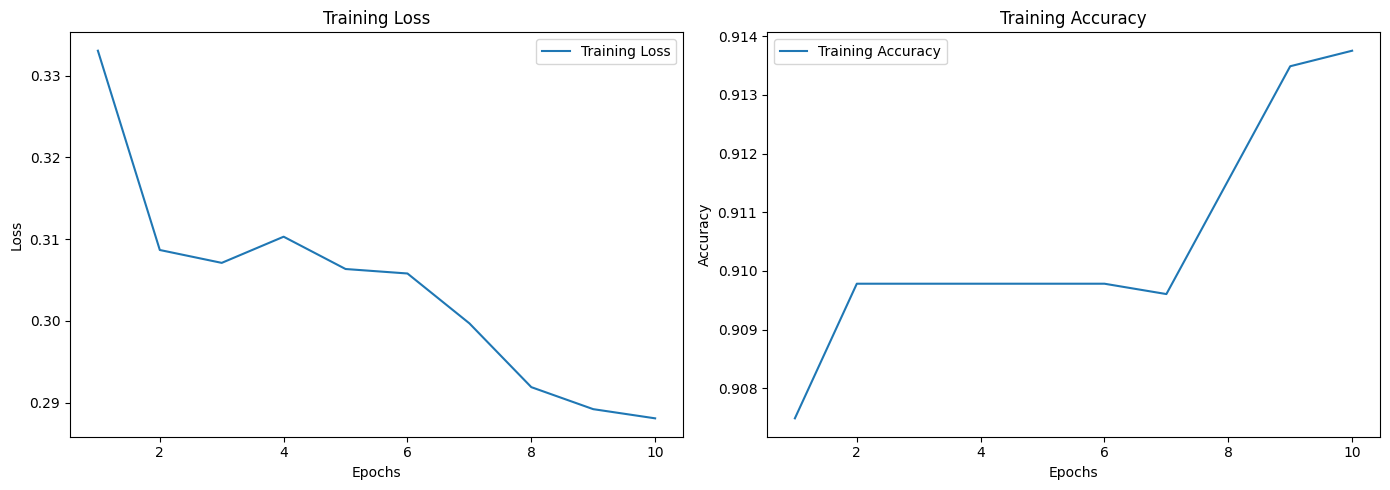

In [59]:
hf.plot_history(history)

## Modeling (2 Aminos Tokenization)

In [60]:
sequence_len = sequences_2p_train.shape[1]
voc_size = len(tokenizer2.word_index)
embedding_dim = 400

### LSTM

In [61]:
inputs = Input(shape=(sequence_len), name='Input')
embeddings = Embedding(input_dim=voc_size, output_dim=embedding_dim, input_length=sequence_len, name='Embeddings')(inputs)

lstms1 = LSTM(20, name='LSTM_layer_1', return_sequences=True)(embeddings)
x = Dropout(0.1)(lstms1)
lstms2 = LSTM(20, name='LSTM_layer_2', return_sequences=True)(x)
x = Dropout(0.1)(lstms1)
lstms3 = LSTM(20, name='LSTM_layer_3')(x)

dense1 = Dense(10, activation='relu', name='Dense_1')(lstms3)
dense2 = Dense(5, activation='relu', name='Dense_2')(dense1)

outputs = Dense(1, activation=tf.keras.activations.hard_sigmoid, name='Output')(dense2)

In [62]:
model_1 = Model(inputs=inputs, outputs=outputs)
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 1014)]            0         
                                                                 
 Embeddings (Embedding)      (None, 1014, 400)         186400    
                                                                 
 LSTM_layer_1 (LSTM)         (None, 1014, 20)          33680     
                                                                 
 dropout_3 (Dropout)         (None, 1014, 20)          0         
                                                                 
 LSTM_layer_3 (LSTM)         (None, 20)                3280      
                                                                 
 Dense_1 (Dense)             (None, 10)                210       
                                                                 
 Dense_2 (Dense)             (None, 5)                 55  

In [63]:
model_1.compile(optimizer=tf.keras.optimizers.Adamax(), loss=tf.keras.losses.binary_focal_crossentropy, metrics=['accuracy'])

In [64]:
history = model_1.fit(sequences_2p_train, labels_2p_train, epochs=2, batch_size=25)

Epoch 1/2
454/454 [==============================] - 47s 100ms/step - loss: 0.0835 - accuracy: 0.9098
Epoch 2/2
454/454 [==============================] - 46s 102ms/step - loss: 0.0828 - accuracy: 0.9098


In [65]:
predictions = model_1.predict(sequences_2p_test)

89/89 [==============================] - 5s 50ms/step


In [66]:
predictions = hf.model_accuracy(labels_2p_test, predictions)

Accuracy:  0.9110483586304271
Loss:  0.4338


In [67]:
hf.class_report(labels_2p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.91      1.00      0.95      2581
    Positive       0.00      0.00      0.00       252

    accuracy                           0.91      2833
   macro avg       0.46      0.50      0.48      2833
weighted avg       0.83      0.91      0.87      2833



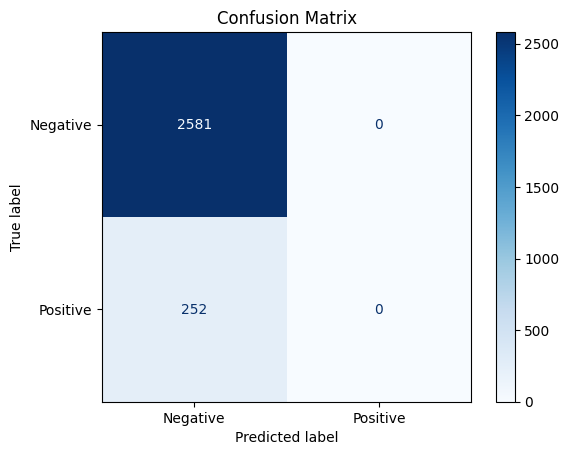

In [68]:
hf.conf_matrix(labels_2p_test, predictions, '2_pair/2p_lstm_baseline_cm')

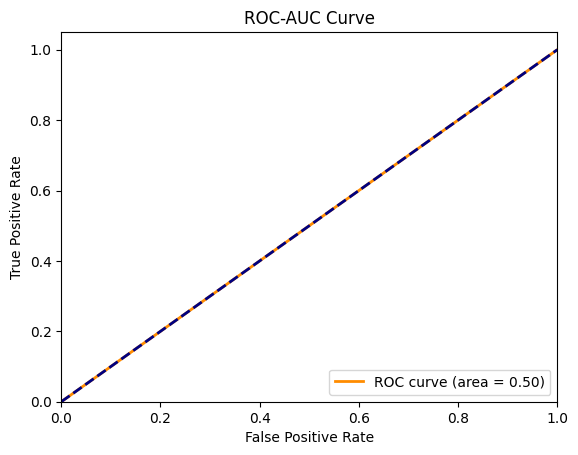

In [69]:
hf.roc_auc_curve(labels_2p_test, predictions, '2_pair/2p_lstm_baseline_roc_auc')

### Transformers

In [70]:
input_layer = Input(shape=(sequence_len), dtype=tf.float32, name='Input')

x = Embedding(input_dim=voc_size, output_dim=embedding_dim, name='Embeddings')(input_layer)

x = PositionalEncoding(position=sequence_len, d_model=embedding_dim)(x)

attention = MultiHeadAttention(num_heads=6, key_dim=embedding_dim, name='Attention1')(x, x)
attention = tf.cast(attention, dtype=tf.float32)  

x = LayerNormalization(epsilon=1e-6, name='LayerNorm1')(x + attention)

dense = Dense(embedding_dim, activation='relu', name='Dense1')(x)
dense = Dense(embedding_dim, activation='relu', name='Dense2')(dense)

x = LayerNormalization(epsilon=1e-6, name='LayerNorm2')(x + dense)
x = GlobalAveragePooling1D(name='GAPooling1D')(x)

outputs_layer = Dense(1, activation="sigmoid", name='Output')(x)

In [71]:
transformer_1 = Model(inputs=input_layer, outputs=outputs_layer)
transformer_1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.binary_crossentropy, metrics=["accuracy"])

In [72]:
transformer_1.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 1014)]               0         []                            
                                                                                                  
 Embeddings (Embedding)      (None, 1014, 400)            186400    ['Input[0][0]']               
                                                                                                  
 positional_encoding_1 (Pos  (None, 1014, 400)            0         ['Embeddings[0][0]']          
 itionalEncoding)                                                                                 
                                                                                                  
 Attention1 (MultiHeadAtten  (None, 1014, 400)            3847600   ['positional_encoding_1[

In [73]:
history = transformer_1.fit(sequences_2p_train, labels_2p_train, epochs=30, batch_size=32)

Epoch 1/30
354/354 [==============================] - 66s 184ms/step - loss: 0.3514 - accuracy: 0.9024
Epoch 2/30
354/354 [==============================] - 64s 180ms/step - loss: 0.3099 - accuracy: 0.9098
Epoch 3/30
354/354 [==============================] - 65s 183ms/step - loss: 0.3062 - accuracy: 0.9098
Epoch 4/30
354/354 [==============================] - 65s 182ms/step - loss: 0.3059 - accuracy: 0.9098
Epoch 5/30
354/354 [==============================] - 65s 184ms/step - loss: 0.2996 - accuracy: 0.9094
Epoch 6/30
354/354 [==============================] - 64s 181ms/step - loss: 0.2916 - accuracy: 0.9114
Epoch 7/30
354/354 [==============================] - 65s 184ms/step - loss: 0.2835 - accuracy: 0.9133
Epoch 8/30
354/354 [==============================] - 65s 183ms/step - loss: 0.2798 - accuracy: 0.9151
Epoch 9/30
354/354 [==============================] - 64s 182ms/step - loss: 0.2742 - accuracy: 0.9152
Epoch 10/30
354/354 [==============================] - 64s 181ms/step - l

In [74]:
predictions = transformer_1.predict(sequences_2p_test)

89/89 [==============================] - 6s 66ms/step


In [75]:
predictions = hf.model_accuracy(labels_2p_test, predictions)

Accuracy:  0.8948111542534416
Loss:  0.3706


In [76]:
hf.class_report(labels_2p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.92      0.97      0.94      2581
    Positive       0.27      0.10      0.15       252

    accuracy                           0.89      2833
   macro avg       0.59      0.54      0.55      2833
weighted avg       0.86      0.89      0.87      2833



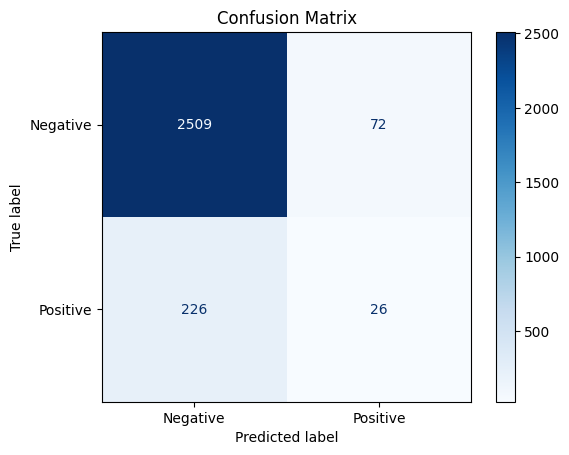

In [77]:
hf.conf_matrix(labels_2p_test, predictions, '2_pair/2p_transformer_1_cm')

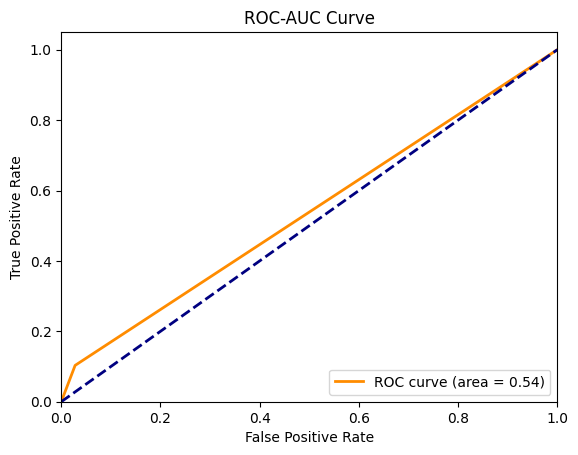

In [78]:
hf.roc_auc_curve(labels_2p_test, predictions, '2_pair/2p_transformer_1_roc_auc')

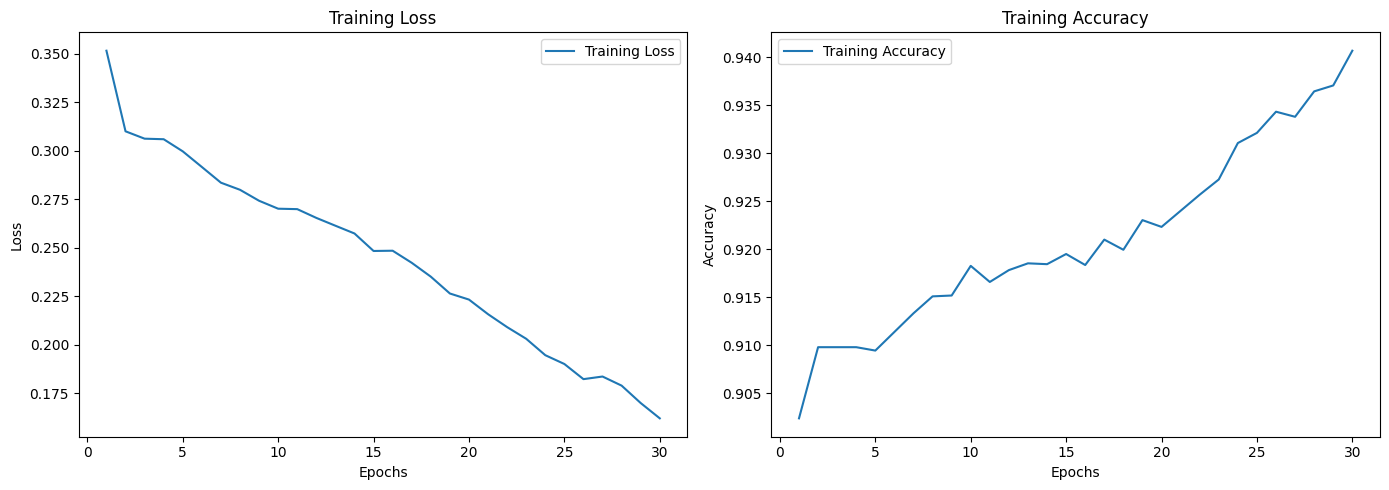

In [79]:
hf.plot_history(history)

## Modeling (3 Aminos Tokenization)

In [41]:
sequence_len = sequences_3p_train.shape[1]
voc_size = len(tokenizer3.word_index)
embedding_dim = 400

### LSTM

In [81]:
inputs = Input(shape=(sequence_len), name='Input')
embeddings = Embedding(input_dim=voc_size, output_dim=embedding_dim, input_length=sequence_len, name='Embeddings')(inputs)

lstms1 = LSTM(20, name='LSTM_layer_1', return_sequences=True)(embeddings)
x = Dropout(0.1)(lstms1)
lstms2 = LSTM(20, name='LSTM_layer_2', return_sequences=True)(x)
x = Dropout(0.1)(lstms1)
lstms3 = LSTM(20, name='LSTM_layer_3')(x)

dense1 = Dense(10, activation='relu', name='Dense_1')(lstms3)
dense2 = Dense(5, activation='relu', name='Dense_2')(dense1)

outputs = Dense(1, activation=tf.keras.activations.hard_sigmoid, name='Output')(dense2)

In [82]:
model_1 = Model(inputs=inputs, outputs=outputs)
model_1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 676)]             0         
                                                                 
 Embeddings (Embedding)      (None, 676, 400)          3390800   
                                                                 
 LSTM_layer_1 (LSTM)         (None, 676, 20)           33680     
                                                                 
 dropout_5 (Dropout)         (None, 676, 20)           0         
                                                                 
 LSTM_layer_3 (LSTM)         (None, 20)                3280      
                                                                 
 Dense_1 (Dense)             (None, 10)                210       
                                                                 
 Dense_2 (Dense)             (None, 5)                 55  

In [90]:
model_1.compile(optimizer=tf.keras.optimizers.Adamax(), loss=tf.keras.losses.binary_focal_crossentropy, metrics=['accuracy'])

In [91]:
history = model_1.fit(sequences_3p_train, labels_3p_train, epochs=8, batch_size=25)

Epoch 1/8
454/454 [==============================] - 66s 143ms/step - loss: 0.0840 - accuracy: 0.9098
Epoch 2/8
454/454 [==============================] - 51s 111ms/step - loss: 0.0828 - accuracy: 0.9098
Epoch 3/8
454/454 [==============================] - 44s 96ms/step - loss: 0.0826 - accuracy: 0.9098
Epoch 4/8
454/454 [==============================] - 41s 91ms/step - loss: 0.0827 - accuracy: 0.9098
Epoch 5/8
454/454 [==============================] - 36s 80ms/step - loss: 0.0827 - accuracy: 0.9098
Epoch 6/8
454/454 [==============================] - 39s 85ms/step - loss: 0.0825 - accuracy: 0.9098
Epoch 7/8
454/454 [==============================] - 36s 80ms/step - loss: 0.0825 - accuracy: 0.9098
Epoch 8/8
454/454 [==============================] - 34s 75ms/step - loss: 0.0827 - accuracy: 0.9098


In [93]:
predictions = model_1.predict(sequences_3p_test)

89/89 [==============================] - 3s 29ms/step


In [94]:
predictions = hf.model_accuracy(labels_3p_test, predictions)

Accuracy:  0.9110483586304271
Loss:  0.4358


In [95]:
hf.class_report(labels_2p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.91      1.00      0.95      2581
    Positive       0.00      0.00      0.00       252

    accuracy                           0.91      2833
   macro avg       0.46      0.50      0.48      2833
weighted avg       0.83      0.91      0.87      2833



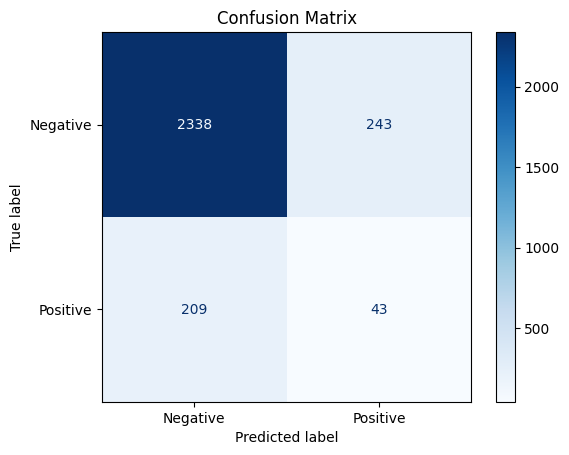

In [58]:
hf.conf_matrix(labels_3p_test, predictions, '3_pair/3p_lstm_baseline_cm')

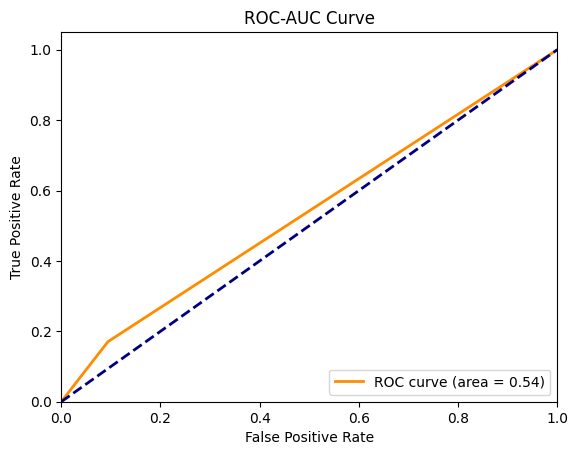

In [59]:
hf.roc_auc_curve(labels_3p_test, predictions, '3_pair/3p_lstm_baseline_roc_auc')

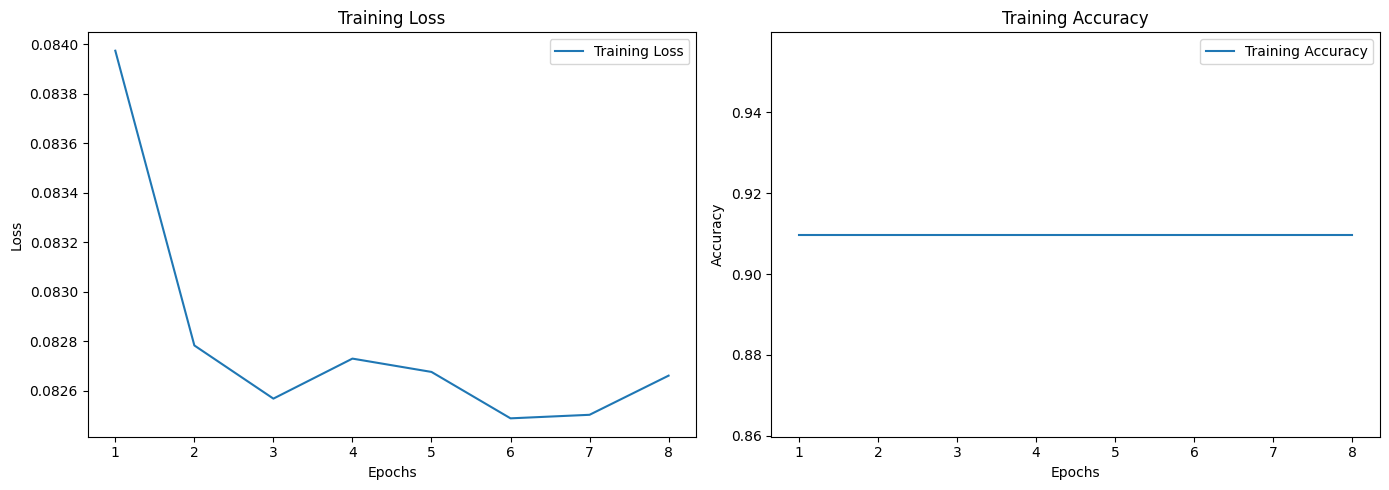

In [98]:
hf.plot_history(history)

### Transformers

In [46]:
input_layer = Input(shape=(sequence_len), dtype=tf.float32, name='Input')

x = Embedding(input_dim=voc_size, output_dim=embedding_dim, name='Embeddings')(input_layer)

x = PositionalEncoding(position=sequence_len, d_model=embedding_dim)(x)

attention = MultiHeadAttention(num_heads=6, key_dim=embedding_dim, name='Attention1')(x, x)
attention = tf.cast(attention, dtype=tf.float32)  

x = LayerNormalization(epsilon=1e-6, name='LayerNorm1')(x + attention)

dense = Dense(embedding_dim, activation='relu', name='Dense1')(x)
dense = Dense(embedding_dim, activation='relu', name='Dense2')(dense)

x = LayerNormalization(epsilon=1e-6, name='LayerNorm2')(x + dense)
x = GlobalAveragePooling1D(name='GAPooling1D')(x)

outputs_layer = Dense(1, activation="sigmoid", name='Output')(x)

In [47]:
transformer_1 = Model(inputs=input_layer, outputs=outputs_layer)
transformer_1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.binary_crossentropy, metrics=["accuracy"])

In [48]:
transformer_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 676)]                0         []                            
                                                                                                  
 Embeddings (Embedding)      (None, 676, 400)             3390800   ['Input[0][0]']               
                                                                                                  
 positional_encoding_1 (Pos  (None, 676, 400)             0         ['Embeddings[0][0]']          
 itionalEncoding)                                                                                 
                                                                                                  
 Attention1 (MultiHeadAtten  (None, 676, 400)             3847600   ['positional_encoding_1[

In [49]:
history = transformer_1.fit(sequences_3p_train, labels_3p_train, epochs=15, batch_size=32)

Epoch 1/15
354/354 [==============================] - 60s 165ms/step - loss: 0.3578 - accuracy: 0.9047
Epoch 2/15
354/354 [==============================] - 53s 149ms/step - loss: 0.3078 - accuracy: 0.9098
Epoch 3/15
354/354 [==============================] - 48s 136ms/step - loss: 0.3063 - accuracy: 0.9098
Epoch 4/15
354/354 [==============================] - 45s 126ms/step - loss: 0.3057 - accuracy: 0.9098
Epoch 5/15
354/354 [==============================] - 45s 127ms/step - loss: 0.2964 - accuracy: 0.9098
Epoch 6/15
354/354 [==============================] - 43s 122ms/step - loss: 0.2779 - accuracy: 0.9095
Epoch 7/15
354/354 [==============================] - 43s 120ms/step - loss: 0.2386 - accuracy: 0.9206
Epoch 8/15
354/354 [==============================] - 41s 117ms/step - loss: 0.1907 - accuracy: 0.9382
Epoch 9/15
354/354 [==============================] - 42s 118ms/step - loss: 0.1355 - accuracy: 0.9593
Epoch 10/15
354/354 [==============================] - 41s 116ms/step - l

In [50]:
predictions = transformer_1.predict(sequences_3p_test)

89/89 [==============================] - 4s 41ms/step


In [51]:
predictions = hf.model_accuracy(labels_3p_test, predictions)

Accuracy:  0.8404518178609248
Loss:  0.8594


In [52]:
hf.class_report(labels_3p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.92      0.91      0.91      2581
    Positive       0.15      0.17      0.16       252

    accuracy                           0.84      2833
   macro avg       0.53      0.54      0.54      2833
weighted avg       0.85      0.84      0.84      2833



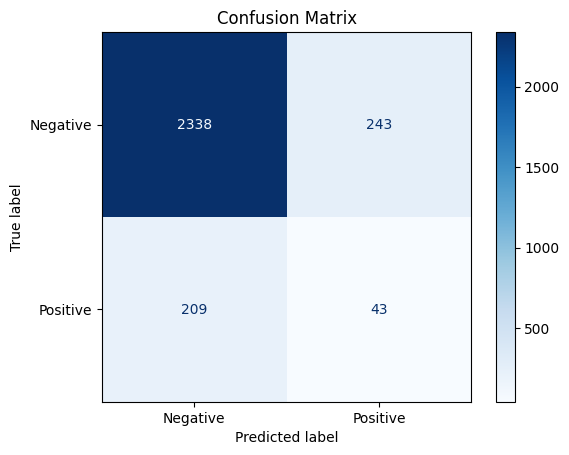

In [57]:
hf.conf_matrix(labels_3p_test, predictions, '3_pair/3p_transformer_1_cm')

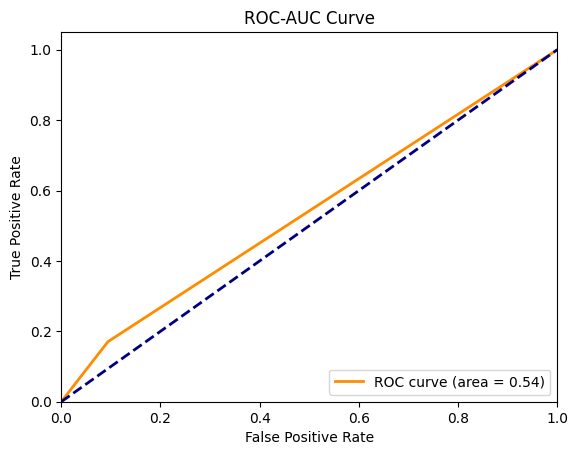

In [56]:
hf.roc_auc_curve(labels_3p_test, predictions, '3_pair/3p_transformer_1_roc_auc')

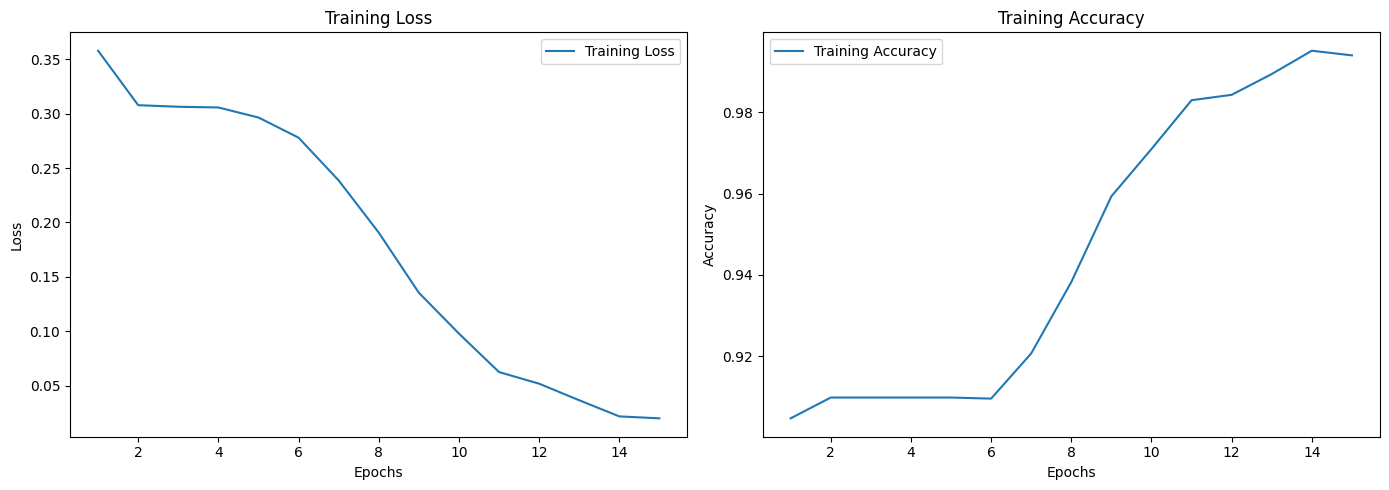

In [55]:
hf.plot_history(history)